In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import gala as ga

import astropy.coordinates as coord
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.table import Table, join
from astroquery.gaia import Gaia

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [3]:
apogee = Table.read("../src/data/allStarLite-dr17-synspec_rev1.fits", hdu=1)

In [4]:
gaia = Table.read("../src/data/allStar-dr17-synspec-gaiaedr3-xm.fits", hdu=1)

In [5]:
tbl = join(apogee, gaia, keys="APOGEE_ID")

In [6]:
clean_tbl = tbl[
      (tbl['LOGG'] > 1) & (tbl['LOGG'] < 5.5)  # realistic spectroscopic stellar parameters (surface gravity)
    & (tbl['TEFF'] > 3500) & (tbl['TEFF'] < 8000)  # same (effective / surface temperature)
    & (tbl['M_H'] > -2) & (tbl['M_H'] < 0.6)  # realistic "bulk metallicity" measurement
    & (tbl['ALPHA_M'] > -1) & (tbl['ALPHA_M'] < 1)  # realistic alpha abundance measurement
    & ((tbl['parallax'] / tbl['parallax_error']) > 8)  # well-measured parallax - the 8 is arbitrary!
]

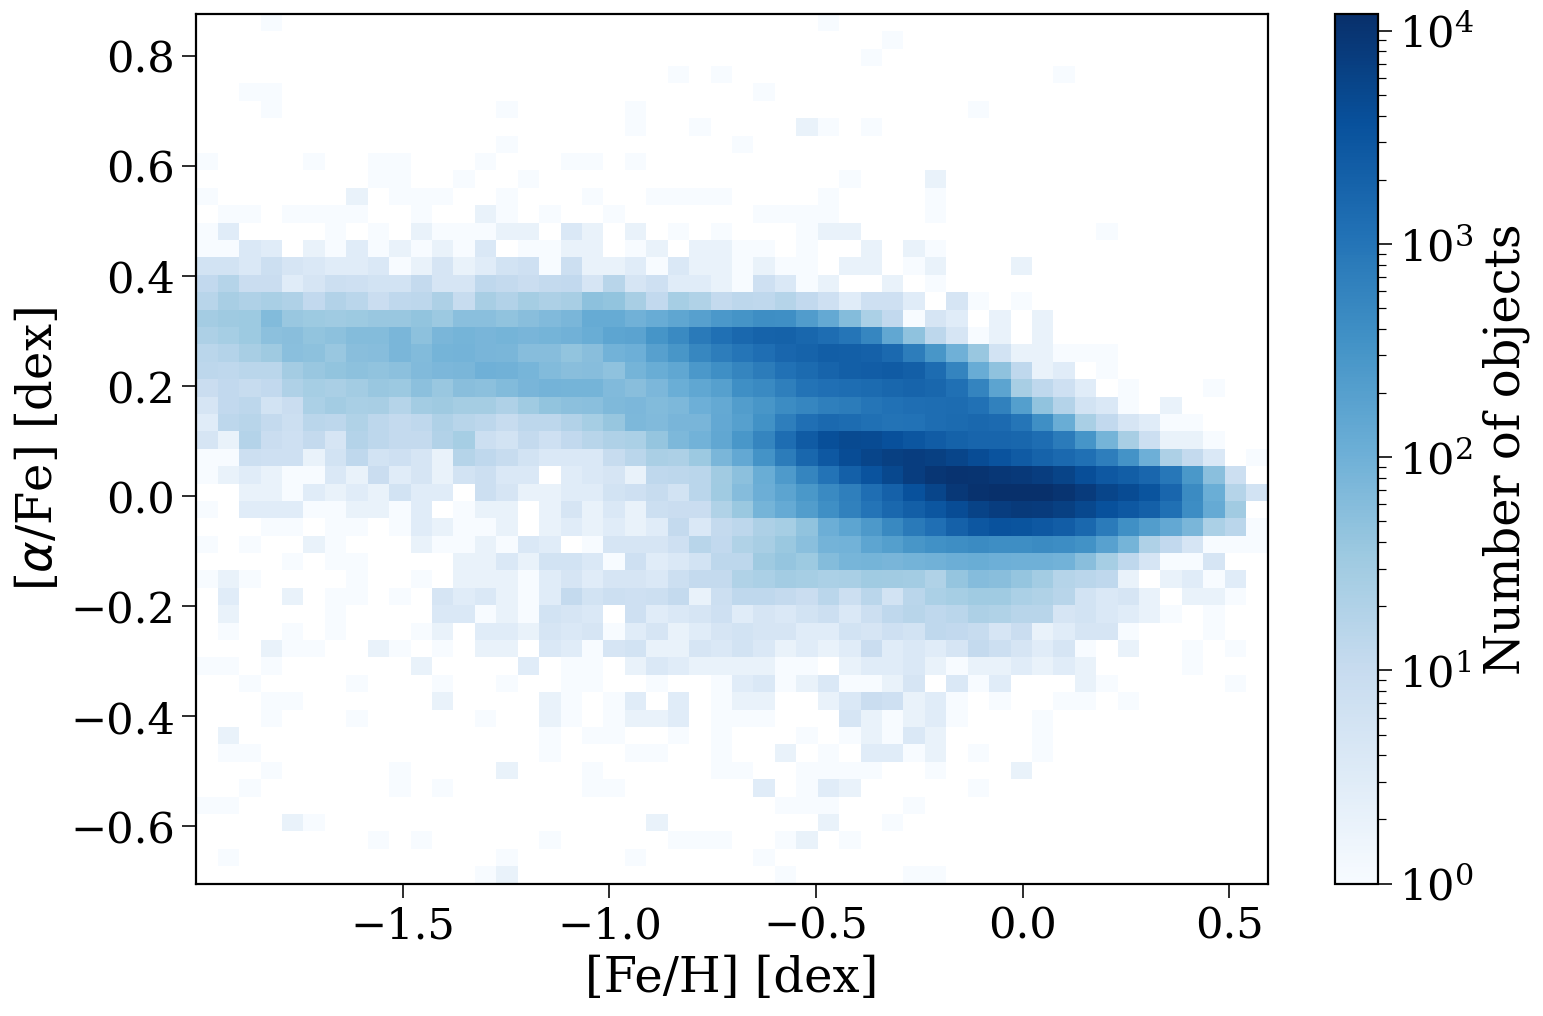

In [7]:
fig, ax = plt.subplots()

counts, xedges, yedges, im = ax.hist2d(clean_tbl["M_H"], clean_tbl["ALPHA_M"], bins=50, norm=LogNorm(), cmap="Blues")

cbar = fig.colorbar(im, ax=ax, label="Number of objects")

ax.set_xlabel("[Fe/H] [dex]")
ax.set_ylabel(r"[$\alpha$/Fe] [dex]")

plt.show()

In [8]:
halo = clean_tbl["M_H"] < -1.25
high_alpha_disc = np.logical_and(clean_tbl["M_H"] > -1, clean_tbl["ALPHA_M"] > 0.2)
low_alpha_disc = np.logical_and(clean_tbl["M_H"] > -1, clean_tbl["ALPHA_M"] < 0.1)

In [9]:
galcen_frame = coord.Galactocentric()

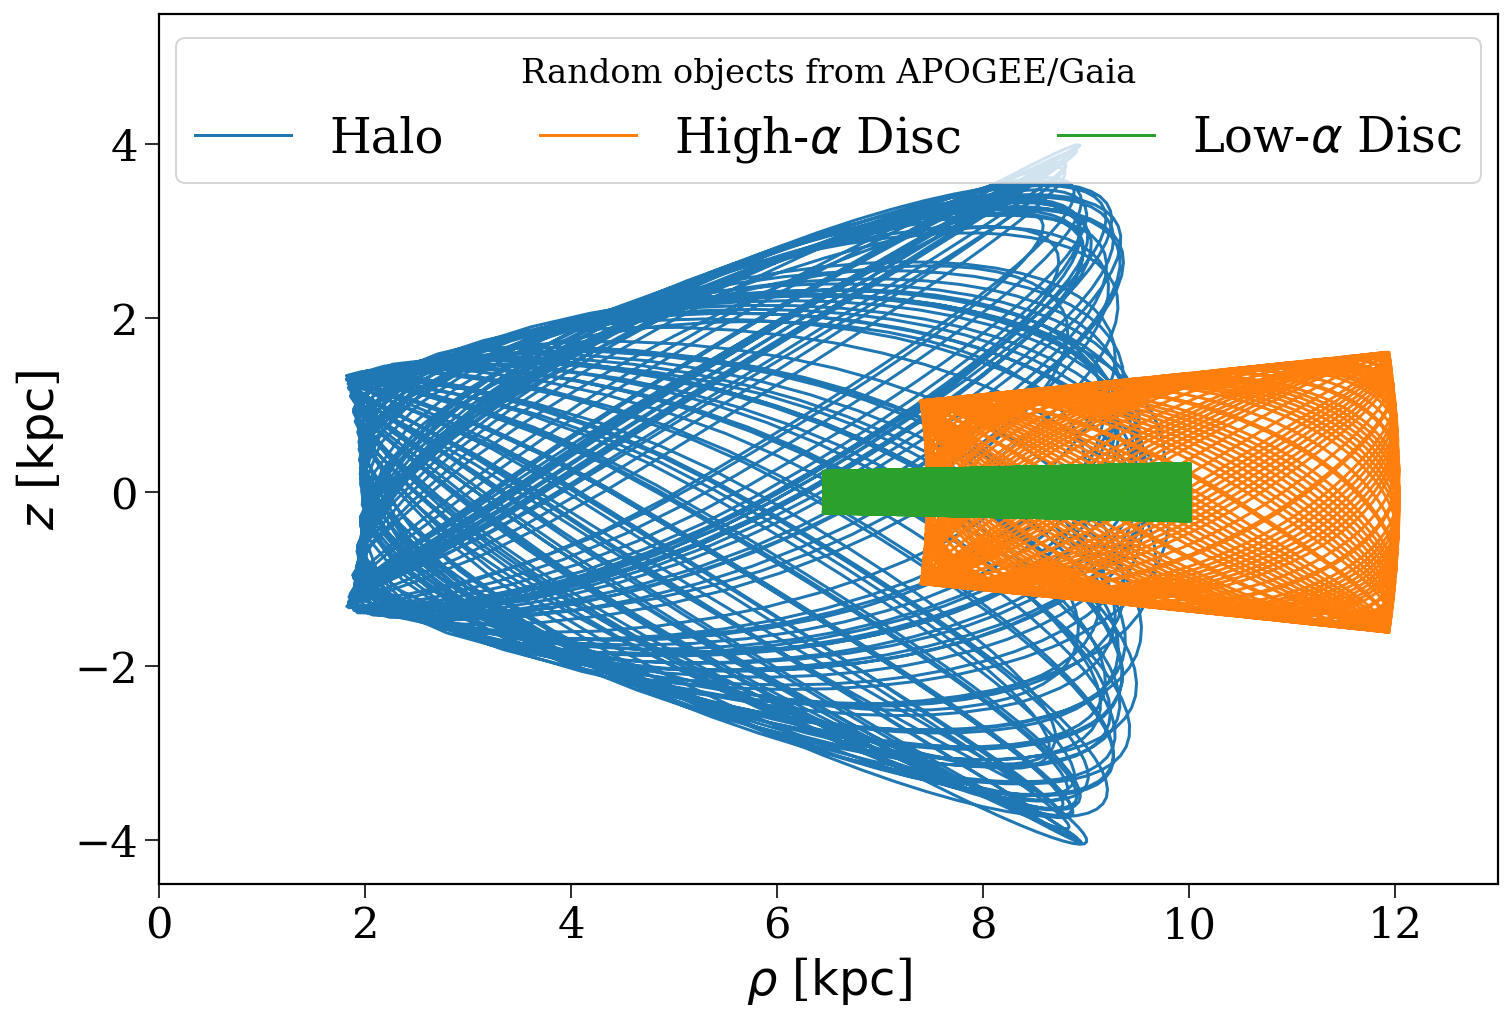

In [10]:
fig, ax = plt.subplots()
pot = ga.potential.MilkyWayPotential()


for mask, label in zip([halo, high_alpha_disc, low_alpha_disc], ["Halo", r"High-$\alpha$ Disc", r"Low-$\alpha$ Disc"]):
    smaller_tbl = clean_tbl[mask]
    some_object = smaller_tbl[0]
    c = coord.SkyCoord(
        ra=some_object["ra"],
        dec=some_object["dec"],
        unit=(u.deg, u.deg),
        distance=(some_object["parallax"] * u.mas).to(u.arcsecond).value**(-1) * u.pc,
        pm_ra_cosdec=some_object["pmra"] * u.mas/u.yr * np.cos(some_object["dec"] * u.deg),
        pm_dec=some_object["pmdec"]*u.mas/u.yr,
        radial_velocity=some_object["dr2_radial_velocity"]*u.km/u.s
    )
    
    pos = ga.dynamics.PhaseSpacePosition(c.transform_to(galcen_frame).data)
    orbits = pot.integrate_orbit(pos, t1=0*u.Gyr, t2=10*u.Gyr, n_steps=4000)
    _ = orbits.cylindrical.plot(['rho', 'z'], axes=[ax], label=label)

leg = ax.legend(ncol=3, title="Random objects from APOGEE/Gaia", loc="upper center")
leg.get_title().set_fontsize(0.7*fs)
    
ax.set_xlim(0, 13)
ax.set_ylim(-4.5, 5.5)
    
plt.show()

# APOGEE Low-$\alpha$ vs. High-$\alpha$ Phase Space Plots

In [11]:
import matplotlib as mpl

_nodes = np.array([
    [-0.5, 0.15],
    [-0.6, 0.15],
    [-0.8, 0.1],
    [-0.7, 0.05],
    [-0.6, 0.03],
    [0, -0.07],
    [0.55, -0.07],
    [0.58, 0.05],
    [0.2, 0.05],
    [-0.5, 0.15]
])
low_alpha_mask = mpl.path.Path(_nodes).contains_points(
    np.stack((clean_tbl['M_H'].data, clean_tbl['ALPHA_M'].data)).T)

_nodes = np.array([
    [0.4, 0.05],
    [0.2, 0.05],
    [-0.5, 0.15],
    [-1, 0.23],
    [-1.3, 0.28],
    [-1.3, 0.35],
    [0, 0.35],
    [0.4, 0.05]
])
high_alpha_mask = mpl.path.Path(_nodes).contains_points(
    np.stack((clean_tbl['M_H'].data, clean_tbl['ALPHA_M'].data)).T)

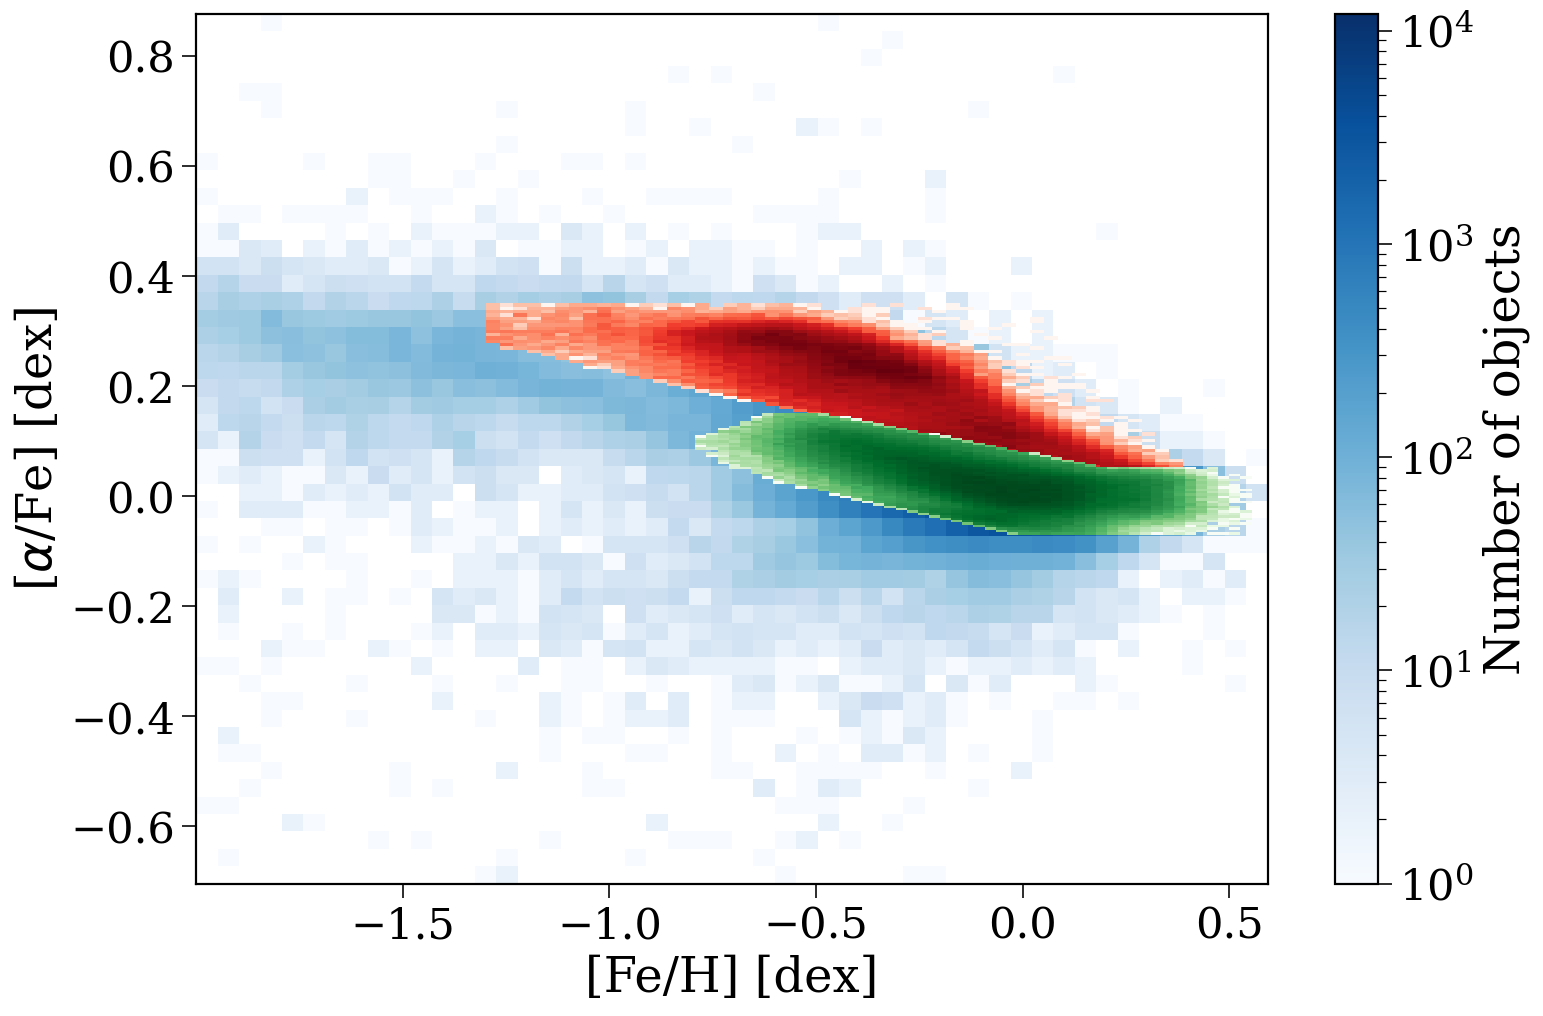

In [12]:
fig, ax = plt.subplots()

counts, xedges, yedges, im = ax.hist2d(clean_tbl["M_H"][high_alpha_mask], clean_tbl["ALPHA_M"][high_alpha_mask], bins=50, norm=LogNorm(), cmap="Reds")
counts, xedges, yedges, im = ax.hist2d(clean_tbl["M_H"][low_alpha_mask], clean_tbl["ALPHA_M"][low_alpha_mask], bins=50, norm=LogNorm(), cmap="Greens")
counts, xedges, yedges, im = ax.hist2d(clean_tbl["M_H"], clean_tbl["ALPHA_M"], bins=50, norm=LogNorm(), cmap="Blues", zorder=-1)

cbar = fig.colorbar(im, ax=ax, label="Number of objects")

ax.set_xlabel("[Fe/H] [dex]")
ax.set_ylabel(r"[$\alpha$/Fe] [dex]")

plt.show()

In [13]:
gal_coords = []

for i, mask in enumerate([high_alpha_mask, low_alpha_mask]):
    coords = coord.SkyCoord(
        ra=clean_tbl[mask]["ra"],
        dec=clean_tbl[mask]["dec"],
        unit=(u.deg, u.deg),
        distance=(clean_tbl[mask]["parallax"].data * u.mas).to(u.arcsecond).value**(-1) * u.pc,
        pm_ra_cosdec=clean_tbl[mask]["pmra"].data * u.mas/u.yr * np.cos(clean_tbl[mask]["dec"].data * u.deg),
        pm_dec=clean_tbl[mask]["pmdec"].data * u.mas/u.yr,
        radial_velocity=clean_tbl[mask]["dr2_radial_velocity"].data * u.km/u.s
    )

    gal_coords.append(coords.transform_to(galcen_frame))

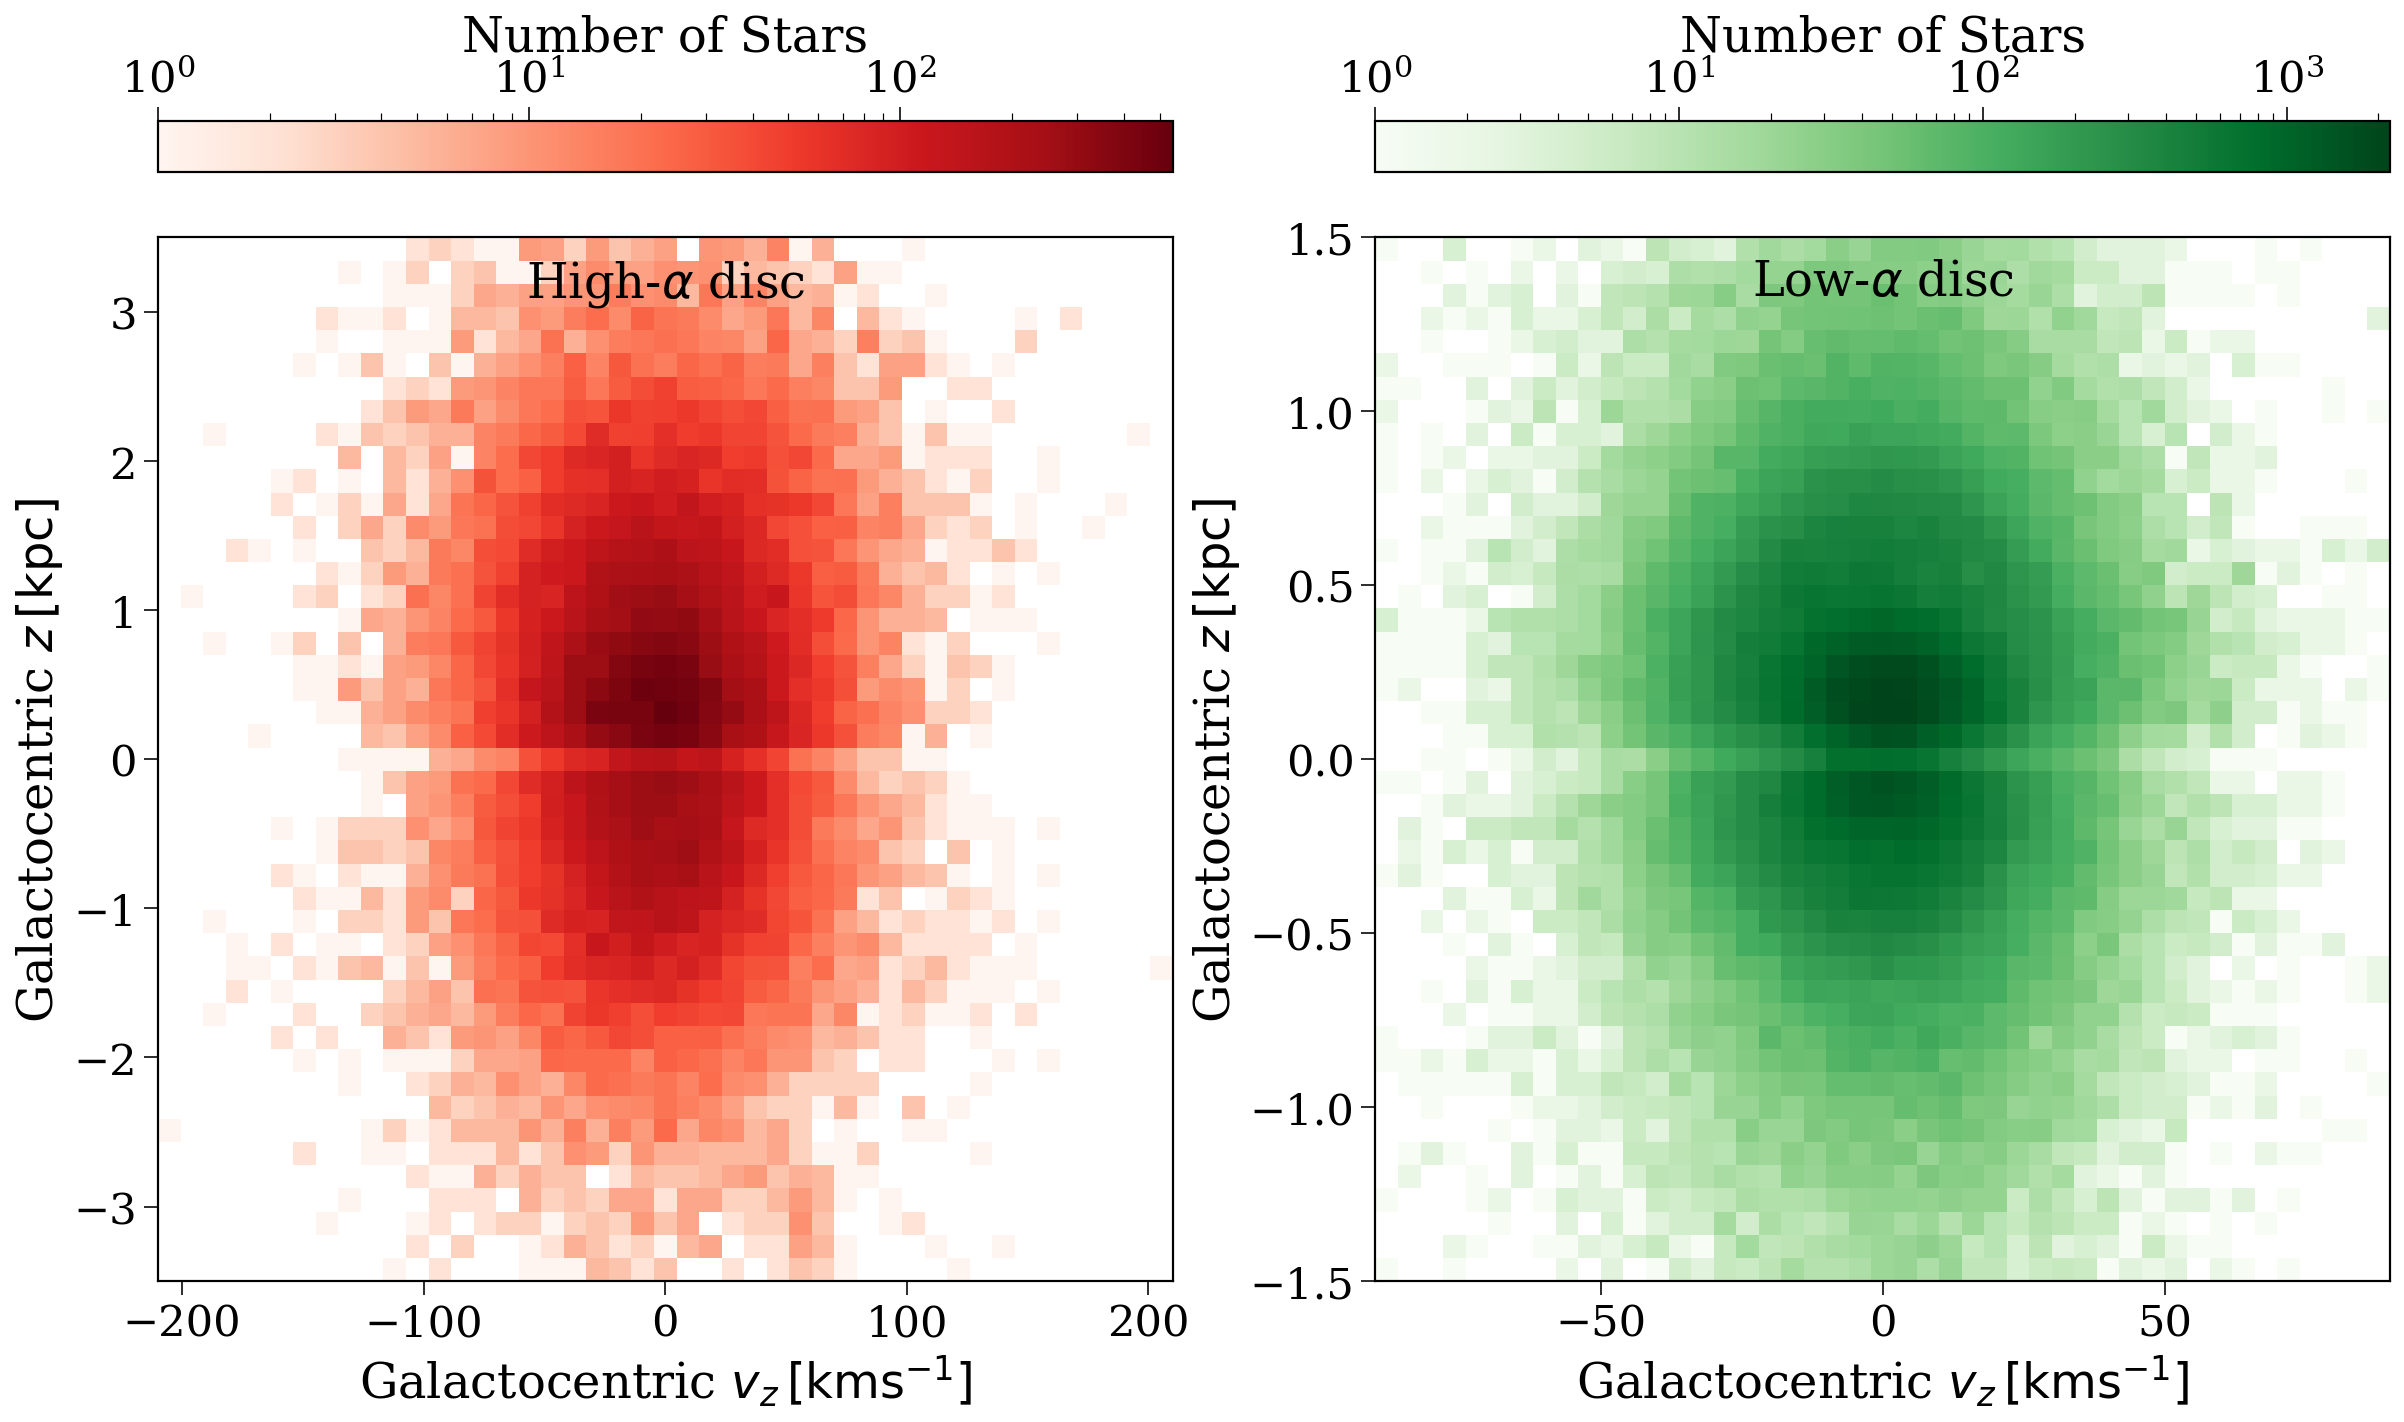

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

ranges = [[[-210, 210], [-3.5, 3.5]], [[-90, 90], [-1.5, 1.5]]]
cmaps = ["Reds", "Greens"]
labels = [r"High-$\alpha$ disc", r"Low-$\alpha$ disc"]

for i in range(len(gal_coords)):
    h = axes[i].hist2d(gal_coords[i].v_z.to(u.km / u.s), gal_coords[i].z.to(u.kpc), bins=45, range=ranges[i], cmap=cmaps[i], norm=LogNorm())
    fig.colorbar(h[3], ax=axes[i], orientation="horizontal", location="top", label="Number of Stars")
    
    axes[i].set_xlabel(r"Galactocentric $v_z \, [\rm km s^{-1}]$")
    axes[i].set_ylabel(r"Galactocentric $z \, [\rm kpc]$")
    axes[i].annotate(labels[i], xy=(0.5, 0.98), xycoords="axes fraction", ha="center", va="top", fontsize=fs)

plt.show()